# Testing Poisson's Relation for two prism

In [2]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import prism
from prism import CM, GRAVITATIONAL_CONST, SI2MGAL, SI2EOTVOS, T2NT
import plot_functions as plf

*Model*

In [11]:
# Two prism
model = np.array([[2000., 3000., -1500., -500., 10., 1010.],
                 [1600., 2600., -2500., -1500., 10., 1010.]])
                 
#magnetization of the prism
# h = magnetization intensity (A/m); inc = inclination (degrees); dec = declination (degrees)
h = 1.3
inc = 30
dec = -45
magnetization = np.array([[h, inc, dec],
                          [h, inc, dec]])

In [12]:
# Cartesian component of magnetization
cos_inc = np.cos(np.deg2rad(inc))
sin_inc = np.sin(np.deg2rad(inc))
cos_dec = np.cos(np.deg2rad(dec))
sin_dec = np.sin(np.deg2rad(dec))
hx_hat = cos_inc*cos_dec
hy_hat = cos_inc*sin_dec
hz_hat = sin_inc

# Density (kg/m³)
rho = 0.8
density = np.zeros(2)+rho

*Testing synthetic data:*

In [13]:
# Number of points along x and y
shape = (100, 100)

# X min/max, Y min/max
area = [-5000, 5000, -4000, 6000]

# Coordinates 
yp = np.linspace(area[0], area[1], shape[0])
xp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 150

coordinates = np.vstack([yp, xp, zp])

*Main field:*

In [14]:
# Reference point
yc, xc = 0, 1000

# Inclination (degrees)
I0 = 60 - 1e-4*(xp-xc) + 3e-4*(yp-yc) + 1e-8*(xp-xc)*(xp-xc) + 1e-8*(yp-yc)*(yp-yc)

# Declination (degrees)
D0 = -43 + 6e-5*(xp-xc) + 1e-4*(yp-yc) + 3e-9*(xp-xc)*(xp-xc) + 4e-9*(yp-yc)*(yp-yc)

# Intensity (nT)
F0 = 23400 + 1e-4*(xp-xc) + 1e-4*(yp-yc) + 0*(xp-xc)*(xp-xc) + 0*(yp-yc)*(yp-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

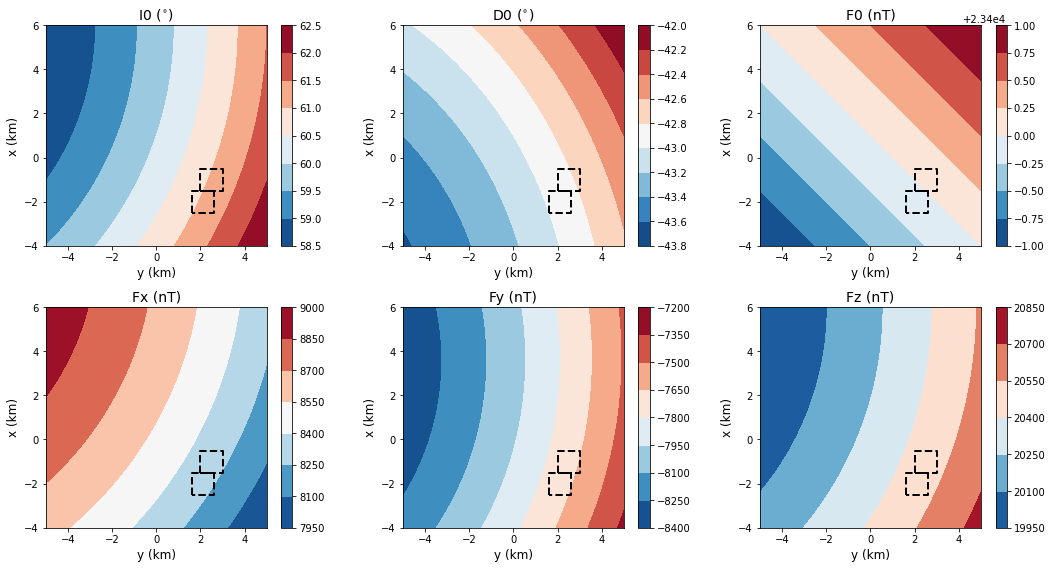

In [15]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

*Synthetic data:*

In [17]:
# Compute the scaler magnetic potential
V = prism.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_potential')

# Compute the magnetic field components
bx = prism.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_x')
by = prism.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_y')
bz = prism.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_z')

# Compute the acceleration components
gx = prism.grav(coordinates=coordinates, prisms=model, density=density, field='g_x')
gy = prism.grav(coordinates=coordinates, prisms=model, density=density, field='g_y')
gz = prism.grav(coordinates=coordinates, prisms=model, density=density, field='g_z')

# Compute the second derivatives
gxx = prism.grav(coordinates=coordinates, prisms=model, density=density, field='g_xx')
gxy = prism.grav(coordinates=coordinates, prisms=model, density=density, field='g_xy')
gxz = prism.grav(coordinates=coordinates, prisms=model, density=density, field='g_xz')
gyy = prism.grav(coordinates=coordinates, prisms=model, density=density, field='g_yy')
gyz = prism.grav(coordinates=coordinates, prisms=model, density=density, field='g_yz')
gzz = prism.grav(coordinates=coordinates, prisms=model, density=density, field='g_zz')

In [20]:
Poisson_ratio = (CM*h)/(GRAVITATIONAL_CONST*rho)
V_Poisson = -(T2NT/SI2MGAL)*Poisson_ratio*(hx_hat*gx + hy_hat*gy + hz_hat*gz)
bx_Poisson = (T2NT/SI2EOTVOS)*Poisson_ratio*(hx_hat*gxx + hy_hat*gxy + hz_hat*gxz)
by_Poisson = (T2NT/SI2EOTVOS)*Poisson_ratio*(hx_hat*gxy + hy_hat*gyy + hz_hat*gyz)
bz_Poisson = (T2NT/SI2EOTVOS)*Poisson_ratio*(hx_hat*gxz + hy_hat*gyz + hz_hat*gzz)

diff_V = V_Poisson - V
diff_bx = bx_Poisson - bx
diff_by = by_Poisson - by
diff_bz = bz_Poisson - bz

*Plot the data:*

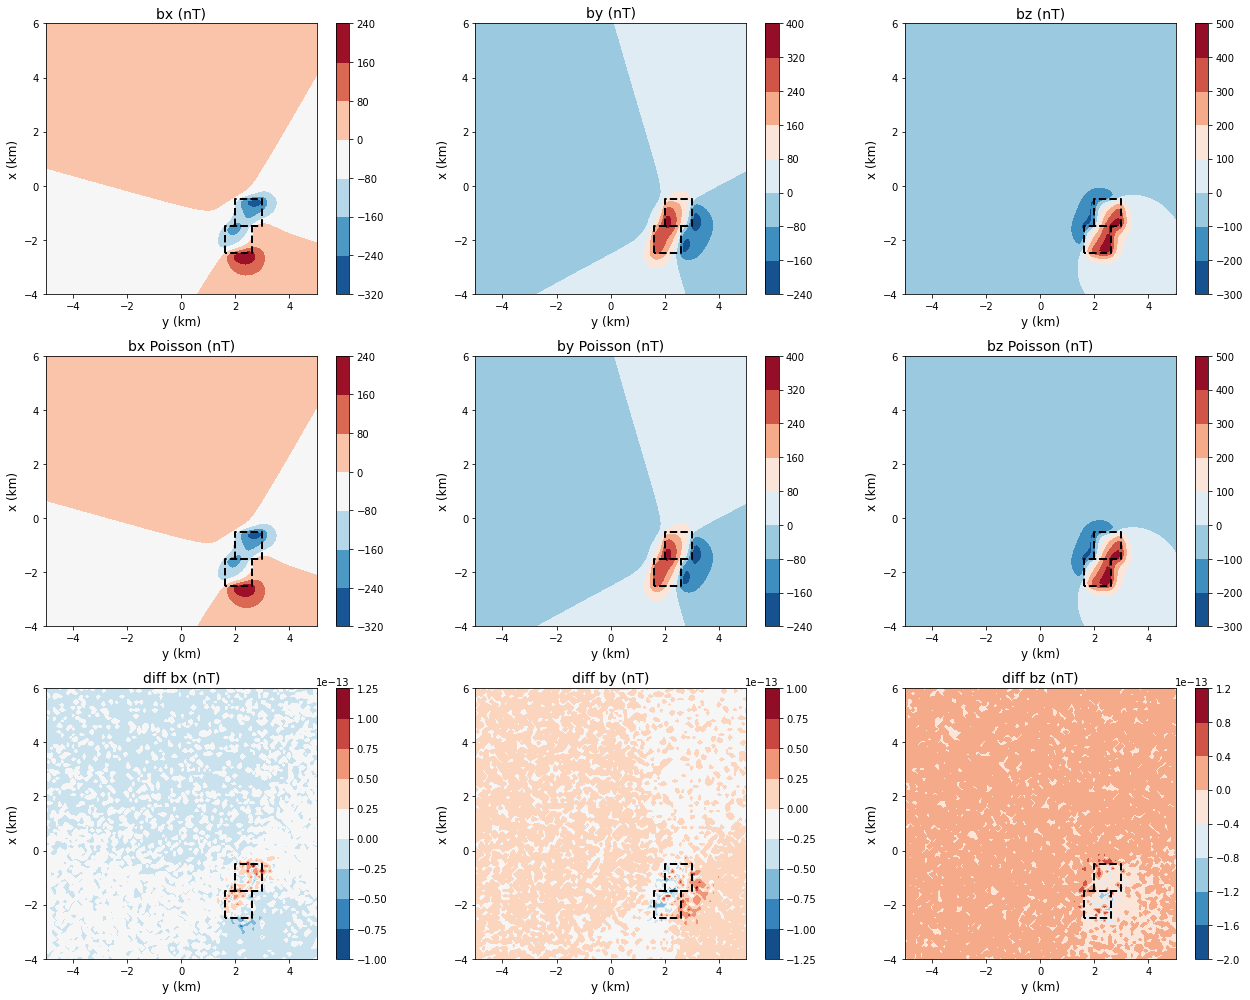

In [21]:
fields = [bx, by, bz, 
          bx_Poisson, by_Poisson, bz_Poisson,
          diff_bx, diff_by, diff_bz]
windows = [1, 2, 3, 4, 5, 6, 7, 8, 9]
titles = ['bx (nT)', 'by (nT)', 'bz (nT)', 
          'bx Poisson (nT)', 'by Poisson (nT)', 'bz Poisson (nT)',
          'diff bx (nT)', 'diff by (nT)', 'diff bz (nT)']

plt.figure(figsize=(18,14))

for w, window in enumerate(windows):

    plt.subplot(3,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

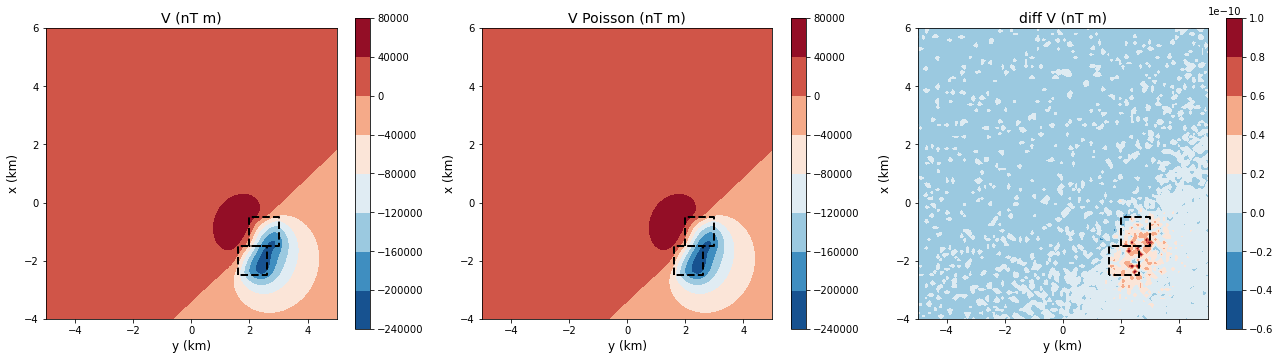

In [22]:
fields = [V, V_Poisson, diff_V]
windows = [1, 2, 3]
titles = ['V (nT m)', 'V Poisson (nT m)', 'diff V (nT m)']

plt.figure(figsize=(18,5))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()